In [ ]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h',name=""):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.savefig(f'{name}_cumulative_return.png')
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.savefig(f'{name}_signal_weight.png')
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [21]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v1.parquet")

In [11]:
df

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,-0.007795,219.4000,351.4194,2328.15940,253.706224,434.108627,1931.153143,30.9855,0.164454,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.003292,253.0935,336.2693,2332.87565,247.173223,435.446110,1934.233818,33.6935,0.153571,...,0,0,0,0,0,0,-0.594000,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,-0.001883,284.9410,309.6284,2338.85115,258.314486,440.377401,1939.227744,31.8475,0.125833,...,1,1,1,0,0,0,-0.396000,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.001648,326.5890,301.5680,2335.72595,243.679390,439.924107,1941.604473,41.6480,0.146164,...,1,1,1,0,0,0,-0.264000,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.000118,351.1670,289.6874,2330.35155,215.620781,435.182264,1941.694715,24.5780,0.075257,...,1,1,1,0,0,0,-0.176000,-0.638306,-0.022000,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,-0.006308,339.3000,312.8600,-1716.76500,92.250077,114.783572,-1486.632740,-329.9500,-0.493015,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.002858,-30.2000,309.9000,-1704.44000,-105.563575,70.973167,-1489.015782,-369.5000,-1.089007,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,-0.004142,-238.4500,313.7300,-1694.03500,-157.957093,47.582523,-1482.887694,-208.2500,6.895695,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.000933,-365.3000,310.7600,-1696.71500,-276.925974,5.335072,-1487.834867,-126.8500,0.531977,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Assume 'return_forward' is the target for classification (e.g., up/down)
# Create a binary target: 1 if return_forward > 0, else 0
df['target'] = (df['return_forward'] > 0).astype(int)
X = df.drop(columns=['return_forward', 'target'])  # Features
# Drop the original target column and any columns not suitable for features

# Feature engineering example: add rolling mean and std for a few features
for col in ['news_count', 'macd_12_26', 'rsi_14']:
    X[f'{col}_rollmean_5'] = X[col].rolling(window=5, min_periods=1).mean()
    X[f'{col}_rollstd_5'] = X[col].rolling(window=5, min_periods=1).std().fillna(0)


# Fill any remaining NaNs
X = X.fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, shuffle=False)

# Train logistic regression
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# # Get absolute value of coefficients and map to feature names
# feature_importance = pd.Series(np.abs(clf.coef_[0]), index=X.columns)
# top_15_features = feature_importance.sort_values(ascending=False).head(15)
# print("Top 15 most important features:")
# print(top_15_features.index)

# Predict and report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64      5088
           1       0.47      0.42      0.44      3677

    accuracy                           0.56      8765
   macro avg       0.54      0.54      0.54      8765
weighted avg       0.55      0.56      0.56      8765



In [25]:
# Create a DataFrame with y_pred and use the index from y_test
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['y_pred'])
y_pred_df

,y_pred
2024-01-01 19:00:00,0
2024-01-01 20:00:00,0
2024-01-01 21:00:00,0
2024-01-01 22:00:00,0
2024-01-01 23:00:00,0
...,...
2024-12-31 19:00:00,0
2024-12-31 20:00:00,0
2024-12-31 21:00:00,0
2024-12-31 22:00:00,0


In [26]:
y_pred_df.index.name = 'date_hour'
y_pred_df.rename(columns={'y_pred': 'signal'}, inplace=True)
y_pred_df

,signal
date_hour,
2024-01-01 19:00:00,0
2024-01-01 20:00:00,0
2024-01-01 21:00:00,0
2024-01-01 22:00:00,0
2024-01-01 23:00:00,0
...,...
2024-12-31 19:00:00,0
2024-12-31 20:00:00,0
2024-12-31 21:00:00,0


Overall Annual Return: 122.74%
Overall Annual Sharpe Ratio: 2.4647
Maximum Drawdown: -24.93 %
Alpha: 0.5729
Beta: 0.4389

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.227416     0.34981     0.438874      0.452923       2.464655


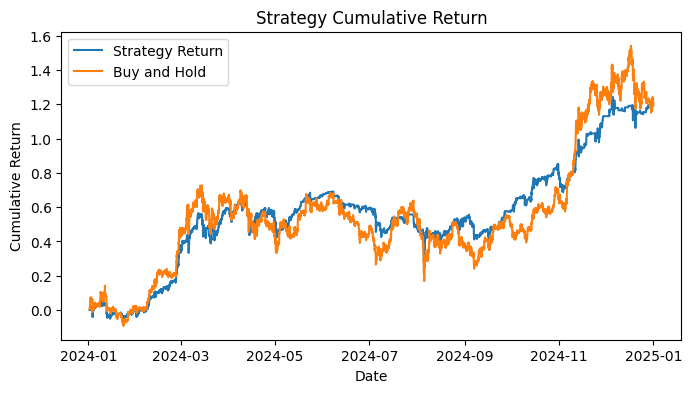

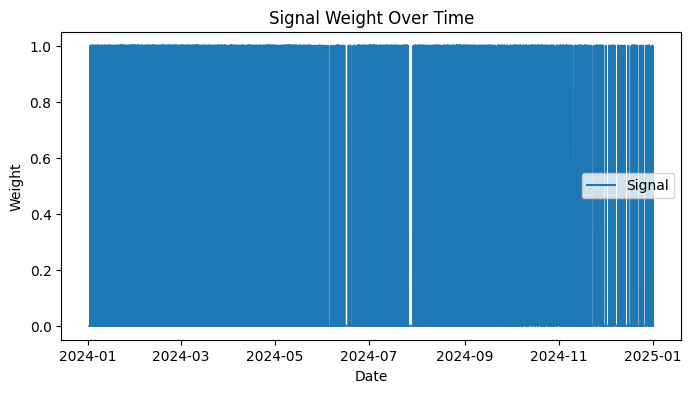

In [27]:
run_backtest(y_pred_df, freq='h', name="logistic_regression_reproduce")